In [76]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import backend as K
import numpy as np
from gensim.models import Word2Vec
import tensorflow as tf
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


combining all text contents to list elements

In [0]:
from os import listdir

def load_doc(filename):
  file = open(filename, 'r')
  text = file.read()
  file.close()
  return text
everyreviewn=[]
counter=0
directory = '/content/gdrive/My Drive/latest/txt_sentoken/pos'
for filename in listdir(directory):
  counter=counter+1
  if not filename.endswith(".txt"):
    continue
#   if(counter>20):
#     break
  path = directory + '/' + filename
  doc = load_doc(path)
  everyreviewn.append(doc)
#   print('Loaded %s' % filename)

writing the list to a dataframe

In [0]:
import csv

with open("/content/gdrive/My Drive/nbsvm/pos1.csv", "a",newline='') as fp:
    wr = csv.writer(fp, dialect='excel')
    wr.writerow(everyreviewn)

In [0]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
pos = pd.read_csv('/content/gdrive/My Drive/nbsvm/pos1.csv',header=None)
neg = pd.read_csv('/content/gdrive/My Drive/nbsvm/neg1.csv',header=None)
pos=pos.transpose()
neg=neg.transpose()
pos.columns = ["comment_text"]
neg.columns = ["comment_text"]
# print(pos,neg)

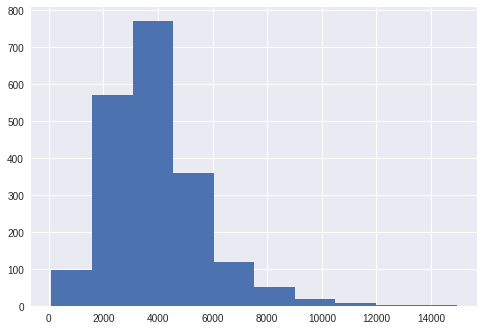

In [146]:
posl = []
negl = []
y    = []
for i in range(1000):
  posl.append(1)
  negl.append(0)

se1= pd.Series(posl)
se2= pd.Series(negl)
pos['label'] = se1.values
neg['label'] = se2.values
Xtotal=pd.concat([pos,neg], ignore_index=True)
lens = Xtotal.comment_text.str.len()
lens.mean(), lens.std(), lens.max()
lens.hist();


shuffle the data frame

In [0]:
X_total = Xtotal.sample(frac=1).reset_index(drop=True)

In [0]:
X_train=X_total[:1500]
X_test=X_total[1500:] 

In [0]:
# print(X_test)

In [150]:
label_cols = ['comment_text']
pos.describe()
COMMENT = 'comment_text'

import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
  return re_tok.sub(r' \1 ', s).split()

# p = pos.shape[0]
# n = neg.shape[0]



vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(X_train[COMMENT])

test_term_doc = vec.transform(X_test[COMMENT])

trn_term_doc, test_term_doc




(<1500x73848 sparse matrix of type '<class 'numpy.float64'>'
 	with 1137724 stored elements in Compressed Sparse Row format>,
 <500x73848 sparse matrix of type '<class 'numpy.float64'>'
 	with 360734 stored elements in Compressed Sparse Row format>)

In [153]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

x = trn_term_doc
test_x = test_term_doc

def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=1, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

preds = np.zeros((len(X_test),len(label_cols)))

# for i, j in enumerate(label_cols):
#     print('fit', j)
m,r = get_mdl(X_train["label"])
preds = m.predict_proba(test_x.multiply(r))[:,1]



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
# print(preds,X_test["label"])
# print(preds[1])
ypred=[]
for i in range(len(preds)):
    if(preds[i]>0.50000):
      ypred.append(1)
    else:
      ypred.append(0)

In [155]:
a=np.array(X_test)
y=a[:,1]
y=np.array(y)
ypred=np.array(ypred)
print(len(y),len(ypred))

500 500


In [157]:
count=0
for i in range(len(ypred)):
  if(y[i]==ypred[i]):
    count=count+1
    
print("accuracy:",count/len(ypred))


accuracy: 0.822
